In [1]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import numpy as np
import matplotlib
import re

import matplotlib.pyplot as plt
from dedalus.extras import plot_tools

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

import os
from os import listdir
# Parameters
Lx, Lz = 40,1
Nx, Nz = 1280, 32
Ra_M = 1.0e6
D_0 = 0
D_H = 1/3
M_0 = 0
M_H = -1
N_s2=4/3
f=0.05

Prandtl = 0.7
dealias = 3/2
stop_sim_time = 2000
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# %%
# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# %%
# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
D = dist.Field(name='D', bases=(xbasis,zbasis))
M = dist.Field(name='M', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
uy = dist.Field(name='uy', bases=(xbasis,zbasis))
Z = dist.Field(name='Z', bases=zbasis)
tau_p = dist.Field(name='tau_p')
tau_B1 = dist.Field(name='tau_B1', bases=xbasis)
tau_B2 = dist.Field(name='tau_B2', bases=xbasis)
tau_D1 = dist.Field(name='tau_D1', bases=xbasis)
tau_D2 = dist.Field(name='tau_D2', bases=xbasis)
tau_M1 = dist.Field(name='tau_M1', bases=xbasis)
tau_M2 = dist.Field(name='tau_M2', bases=xbasis)
tau_u1 = dist.VectorField(coords,name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords,name='tau_u2', bases=xbasis)
tau_u3 = dist.Field(name='tau_u3', bases=xbasis)
tau_u4 = dist.Field(name='tau_u4', bases=xbasis)

# Substitutions    
#Kuo_Bretherton Equilibrium
kappa = (Ra_M * Prandtl/((M_0-M_H)*Lz**3))**(-1/2)
nu = (Ra_M / (Prandtl*(M_0-M_H)*Lz**3))**(-1/2)
print('kappa',kappa)
print('nu',nu)
Td=Lz**2/(nu*kappa)**(1/2)
Tc=(Lz/(M_0-M_H))**(1/2)
Tr=1/f
R_0=Tr/Tc
print('R_0',R_0)


x,z = dist.local_grids(xbasis,zbasis)
Z['g']=z
Z.change_scales(3/2)

ex,ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

B_op = (np.absolute(D - M - N_s2*Z)+ M + D - N_s2*Z)/2

Max = lambda A,B: (abs(A-N_s2*Z-B)+A-N_s2*Z+B)/2
eva = lambda A: A.evaluate()

dz= lambda A: d3.Differentiate(A, coords['z'])
dx= lambda A: d3.Differentiate(A, coords['x'])

ux=u@ex
uz=u@ez
dxux=dx(ux)
dzux=dz(ux)
dxuz=dx(uz)
dzuz=dz(uz)

ux2=ux*ux
uy2=uy*uy
uz2=uz*uz

grad_u = d3.grad(u) + ez* lift(tau_u1) # First-order reduction
grad_ux = grad_u@ex # First-order reduction
grad_uz = grad_u@ez # First-order reduction
grad_uy = d3.grad(uy) + ez*lift(tau_u3)# First-order reduction 
grad_M = d3.grad(M) + ez*lift(tau_M1) # First-order reduction
grad_D = d3.grad(D) + ez*lift(tau_D1) # First-order reduction


kappa 0.0011952286093343937
nu 0.0008366600265340755
R_0 20.0


In [2]:
folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
print(file_paths)

n = 0
if not os.path.exists('rotational'):
    os.mkdir('rotational')

for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['M']
        print(np.shape(moistbuoyancy))
        break

['snapshots/snapshots_s1.h5', 'snapshots/snapshots_s2.h5', 'snapshots/snapshots_s3.h5', 'snapshots/snapshots_s4.h5', 'snapshots/snapshots_s5.h5', 'snapshots/snapshots_s6.h5', 'snapshots/snapshots_s7.h5', 'snapshots/snapshots_s8.h5', 'snapshots/snapshots_s9.h5', 'snapshots/snapshots_s10.h5', 'snapshots/snapshots_s11.h5', 'snapshots/snapshots_s12.h5', 'snapshots/snapshots_s13.h5', 'snapshots/snapshots_s14.h5', 'snapshots/snapshots_s15.h5', 'snapshots/snapshots_s16.h5', 'snapshots/snapshots_s17.h5', 'snapshots/snapshots_s18.h5', 'snapshots/snapshots_s19.h5', 'snapshots/snapshots_s20.h5', 'snapshots/snapshots_s21.h5', 'snapshots/snapshots_s22.h5', 'snapshots/snapshots_s23.h5', 'snapshots/snapshots_s24.h5', 'snapshots/snapshots_s25.h5', 'snapshots/snapshots_s26.h5', 'snapshots/snapshots_s27.h5', 'snapshots/snapshots_s28.h5', 'snapshots/snapshots_s29.h5', 'snapshots/snapshots_s30.h5', 'snapshots/snapshots_s31.h5', 'snapshots/snapshots_s32.h5', 'snapshots/snapshots_s33.h5', 'snapshots/snapsho

In [ ]:

folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
print(file_paths)

n = 0
if not os.path.exists('rotational'):
    os.mkdir('rotational')

for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['M']
        drybuoyancy = file['tasks']['D']
        buoyancy = np.maximum(moistbuoyancy, drybuoyancy - N_s2 * z)
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(0, len(simtime)):
            mb = np.transpose(moistbuoyancy[t, :, :])
            db = np.transpose(drybuoyancy[t, :, :])
            bu = np.transpose(buoyancy[t, :, :])
            plt.contourf(bu, cmap='RdBu_r')
            plt.colorbar(label='buoyancy')
            plt.xlabel('x')
            plt.ylabel('z')
            n = n + 1
            # Add time title
            title = "t=" + str(simtime[t])
            plt.title(title)
            plt.savefig(f'rotational/rot_ {"%04d" % n} .png', dpi=200, bbox_inches='tight')
            matplotlib.pyplot.close()

['snapshots/snapshots_s1.h5', 'snapshots/snapshots_s2.h5', 'snapshots/snapshots_s3.h5', 'snapshots/snapshots_s4.h5', 'snapshots/snapshots_s5.h5', 'snapshots/snapshots_s6.h5', 'snapshots/snapshots_s7.h5', 'snapshots/snapshots_s8.h5', 'snapshots/snapshots_s9.h5', 'snapshots/snapshots_s10.h5', 'snapshots/snapshots_s11.h5', 'snapshots/snapshots_s12.h5', 'snapshots/snapshots_s13.h5', 'snapshots/snapshots_s14.h5', 'snapshots/snapshots_s15.h5', 'snapshots/snapshots_s16.h5', 'snapshots/snapshots_s17.h5', 'snapshots/snapshots_s18.h5', 'snapshots/snapshots_s19.h5', 'snapshots/snapshots_s20.h5', 'snapshots/snapshots_s21.h5', 'snapshots/snapshots_s22.h5', 'snapshots/snapshots_s23.h5', 'snapshots/snapshots_s24.h5', 'snapshots/snapshots_s25.h5', 'snapshots/snapshots_s26.h5', 'snapshots/snapshots_s27.h5', 'snapshots/snapshots_s28.h5', 'snapshots/snapshots_s29.h5', 'snapshots/snapshots_s30.h5', 'snapshots/snapshots_s31.h5', 'snapshots/snapshots_s32.h5', 'snapshots/snapshots_s33.h5', 'snapshots/snapsho

In [ ]:

folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
print(file_paths)

n = 0
if not os.path.exists('rotational_uy'):
    os.mkdir('rotational_uy')

for file in file_paths:
    with h5py.File(file, mode='r') as file:
        uuyy = file['tasks']['uy']
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(0, len(simtime)):
            uuuyyy = np.transpose(uuyy[t, :, :])
            plt.contourf(uuuyyy, cmap='RdBu_r')
            plt.colorbar(label='uy component')
            plt.xlabel('x')
            plt.ylabel('z')
            n = n + 1
            # Add time title
            title = "t=" + str(simtime[t])
            plt.title(title)
            plt.savefig(f'rotational_uy/rot_uy_{"%04d" % n}.png', dpi=200, bbox_inches='tight')
            matplotlib.pyplot.close()

In [ ]:
folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
print(file_paths)

n = 0
if not os.path.exists('moist buoyancy'):
    os.mkdir('moist buoyancy')

for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['M']
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(0, len(simtime)):
            mb = np.transpose(moistbuoyancy[t, :, :])
            plt.contourf(mb, cmap='RdBu_r')
            plt.colorbar(label='moist buoyancy')
            plt.xlabel('x')
            plt.ylabel('z')
            n = n + 1
            # Add time title
            title = "t=" + str(simtime[t])
            plt.title(title)
            plt.savefig(f'moist buoyancy/mb_ {"%04d" % n} .png', dpi=200, bbox_inches='tight')
            matplotlib.pyplot.close()

['analysis/analysis_s1.h5', 'analysis/analysis_s2.h5', 'analysis/analysis_s3.h5', 'analysis/analysis_s4.h5', 'analysis/analysis_s5.h5', 'analysis/analysis_s6.h5', 'analysis/analysis_s7.h5', 'analysis/analysis_s8.h5', 'analysis/analysis_s9.h5', 'analysis/analysis_s10.h5']


KeyboardInterrupt: 

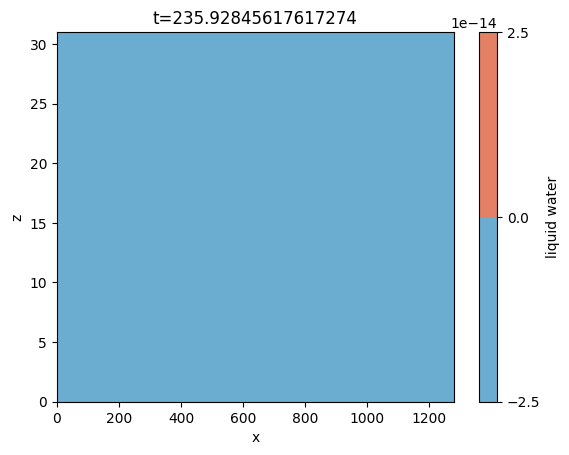

In [2]:
folder_dir = "analysis"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
print(file_paths)

if not os.path.exists('liquid water'):    
    os.mkdir('liquid water')
n=0
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['moist buoyancy']
        drybuoyancy = file['tasks']['dry buoyancy']
        ql=np.maximum(moistbuoyancy[:]-drybuoyancy[:]+N_s2*z,0)
        st = file['scales/sim_time']
        for t in range(50):
            qli=np.transpose(ql[t,:,:])
            plt.contourf(qli, cmap='RdBu_r')
            plt.colorbar(label='liquid water')
            plt.xlabel('x')
            plt.ylabel('z')
            n=n+1
            # Add time title
            title = "t="+str(st[t])
            plt.title(title)
            plt.savefig(f'liquid water/liquidwater_{"%04d" % n}.png', dpi=200,bbox_inches='tight')
            matplotlib.pyplot.close()